This is my attempt to the titanic dataset so far. The highest score is 0.77990, which is a slight improvement compared to the Kaggle baseline model which scores 0.77751. 

In [1]:
import numpy as np
import pandas as pd
import re
 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

# Features

The *train_data* and the *test_data* have the same columns, except that the *Survived* column only appears in the *train_data*. We note that there are missing values in the *Cabin* column.

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


There are around 180 missing values in the *Age* column, 690 missing values in the *Cabin* column, and 2 missing values in the *Embarked* column in *train_data*. In *test_data*, there are also missing values in the *Age* and the *Cabin* columns. Additionally, there is a missing value in the *Fare* column in *test_data*.

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


We will first impute the *Embarked* column by mode because only 2 values are missing and it is a small proportion of the whole dataset. 

In [6]:
embarked_mode = pd.concat([train_data, test_data])['Embarked'].mode()[0]
train_data['Embarked'] = train_data['Embarked'].fillna(embarked_mode)

The percentage of passengers with *Cabin* are highest for first class and lowest for third class.

In [7]:
pd.concat([train_data, test_data])[pd.concat([train_data, test_data])['Pclass'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Index: 323 entries, 1 to 414
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  323 non-null    int64  
 1   Survived     216 non-null    float64
 2   Pclass       323 non-null    int64  
 3   Name         323 non-null    object 
 4   Sex          323 non-null    object 
 5   Age          284 non-null    float64
 6   SibSp        323 non-null    int64  
 7   Parch        323 non-null    int64  
 8   Ticket       323 non-null    object 
 9   Fare         323 non-null    float64
 10  Cabin        256 non-null    object 
 11  Embarked     323 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 32.8+ KB


In [8]:
pd.concat([train_data, test_data])[pd.concat([train_data, test_data])['Pclass'] == 2].info()

<class 'pandas.core.frame.DataFrame'>
Index: 277 entries, 9 to 406
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  277 non-null    int64  
 1   Survived     184 non-null    float64
 2   Pclass       277 non-null    int64  
 3   Name         277 non-null    object 
 4   Sex          277 non-null    object 
 5   Age          261 non-null    float64
 6   SibSp        277 non-null    int64  
 7   Parch        277 non-null    int64  
 8   Ticket       277 non-null    object 
 9   Fare         277 non-null    float64
 10  Cabin        23 non-null     object 
 11  Embarked     277 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 28.1+ KB


In [9]:
pd.concat([train_data, test_data])[pd.concat([train_data, test_data])['Pclass'] == 3].info()

<class 'pandas.core.frame.DataFrame'>
Index: 709 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  709 non-null    int64  
 1   Survived     491 non-null    float64
 2   Pclass       709 non-null    int64  
 3   Name         709 non-null    object 
 4   Sex          709 non-null    object 
 5   Age          501 non-null    float64
 6   SibSp        709 non-null    int64  
 7   Parch        709 non-null    int64  
 8   Ticket       709 non-null    object 
 9   Fare         708 non-null    float64
 10  Cabin        16 non-null     object 
 11  Embarked     709 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 72.0+ KB


We will fill missing values in the first, second and third class by X, Y, Z, and extract the *cabin_class* feature from this column.

In [10]:
def extract_cabin(data):
    data.loc[data['Pclass']==1, 'Cabin'] = data.loc[data['Pclass']==1, 'Cabin'].fillna('X')
    data.loc[data['Pclass']==2, 'Cabin'] = data.loc[data['Pclass']==2, 'Cabin'].fillna('Y')
    data.loc[data['Pclass']==3, 'Cabin'] = data.loc[data['Pclass']==3, 'Cabin'].fillna('Z')
    data['Cabin'] = data['Cabin'].apply(lambda x: x.split(' '))
    data['cabin_class'] = data['Cabin'].apply(lambda l: ','.join(list(set([re.findall(r'([A-Z]+)',x)[0] for x in l]))))
    data.drop(columns=['Cabin'], inplace = True)
    return data

In [11]:
train_data = extract_cabin(train_data)
test_data = extract_cabin(test_data)

Now we have filled all the missing values in *train_data*. As for the missing *Fare* values in the *test_data*, we again use mean imputation and we created a new *fare_per_person* feature.

In [12]:
ticket_counts = pd.concat([train_data,test_data]).groupby('Ticket').size().reset_index(name='ticket_counts')

def add_fare_per_person(data):
    data = data.merge(ticket_counts, on = 'Ticket', how = 'left')
    data['fare_per_person'] = data['Fare']/data['ticket_counts']
    return data

train_data = add_fare_per_person(train_data)
test_data = add_fare_per_person(test_data)

mean_fare_per_person = test_data['fare_per_person'].mean()
test_data['fare_per_person'] = test_data['fare_per_person'].fillna(mean_fare_per_person)
mean_fare = test_data['Fare'].mean()
test_data['Fare'] = test_data['Fare'].fillna(mean_fare)

In [13]:
train_data.groupby(['cabin_class'])['fare_per_person'].agg({'mean','std'})

,std,mean
cabin_class,,
A,11.822944,32.354767
B,24.324002,39.153090
C,8.536412,34.729590
D,7.967485,28.458462
E,8.264772,23.390192
F,1.548409,9.694444
"F,E",NaN,7.452767
"F,G",0.000000,7.650000
G,0.193653,5.398958


In [14]:
train_data['Sex'] = train_data['Sex'].map({'female':1,'male':0})
test_data['Sex'] = test_data['Sex'].map({'female':1,'male':0})

We created the *family_size* and *family_id* label because it is possible that those with a large family size had to take care of many family members and they are less likely to survive compared to those with a small family.

In [15]:
train_data['family_size'] = train_data['SibSp']+train_data['Parch']+1
test_data['family_size'] = test_data['SibSp']+test_data['Parch']+1

In [16]:
def add_family_id(data):
    data['last_name'] = data['Name'].str.split(',').str[0]
    data['family_id'] = data['family_size'].astype(str)+data['last_name']
    data['family_id2'] = data['family_id']
    data.loc[data['family_size']<=3,'family_id2'] = 'Small'
    return data

train_data = add_family_id(train_data)
test_data = add_family_id(test_data)

Now, we move on to the *Age* variable and we are going to apply mean imputation by groups for missing values. For example, the 'Master' title is for young boys and 'Miss' or 'Mlle' (Mademoiselle in French) titles are for young ladies. I also tried impute missing values by decision tree. Since we intend to fit tree models at later stage, and these models are quite sensitive to one-hot encoded data, we will also reduce the number of titles a bit by merging similar ones, e.g. mering 'Mrs' and 'Ms', merging honorable titles like 'Capt', 'Don' to 'Sir'.

In [17]:
train_data['title'] = train_data['Name'].str.extract(r'([A-Za-z]+)\.')
test_data['title'] = test_data['Name'].str.extract(r'([A-Za-z]+)\.')

def clean_title(data):
    data['title'] = data['title'].replace('Mlle', 'Miss')
    data['title'] = data['title'].replace({'Mme':'Ms', 'Mrs':'Ms'})
    data['title'] = data['title'].replace({'Capt':'Sir', 'Don': 'Sir', 'Major': 'Sir', 'Rev': 'Sir', 'Col':'Sir'})
    data['title'] = data['title'].replace({'Dona':'Lady','Countess':'Lady', 'Jonkheer':'Lady'})
    data.loc[(data['title'] == 'Dr') & (data['Sex'] == 'female'), 'title'] = 'Lady'
    data.loc[(data['title'] == 'Dr') & (data['Sex'] == 'male'), 'title'] = 'Sir'
    return data

train_data = clean_title(train_data)
test_data = clean_title(test_data)

def fill_age_by_mean(data):
    master_mean_age = data.loc[data['title']=='Master','Age'].mean()
    miss_mean_age = data.loc[data['title']=='Miss','Age'].mean()
    rest_mean_age = data.loc[(data['title']!='Master') & (data['title']!='Miss'),'Age'].mean()
    data.loc[data['title']=='Master','Age'] = data.loc[data['title']=='Master','Age'].fillna(master_mean_age)
    data.loc[data['title']=='Miss','Age'] = data.loc[data['title']=='Miss','Age'].fillna(miss_mean_age)
    data.loc[(data['title']!='Master') & (data['title']!='Miss'),'Age'] = data.loc[(data['title']!='Master') & (data['title']!='Miss'),'Age'].fillna(rest_mean_age)
    return data

def fill_age_by_decision_tree(train_data,test_data):
    features = ['Pclass', "Sex", 'SibSp', 'Parch', 'Fare', 'Embarked','title','family_size']
    df = pd.concat([train_data,test_data])
    combined_data = pd.get_dummies(df[features])
    clf = DecisionTreeRegressor(min_impurity_decrease = 0.005)
    clf.fit(combined_data.loc[~df['Age'].isna()],df.loc[~df['Age'].isna()]['Age'])
    df.loc[df['Age'].isna(),'Age'] = clf.predict(combined_data.loc[df['Age'].isna()])
    return df[:len(train_data)], df[len(train_data):]
    
train_data = fill_age_by_mean(train_data)
test_data = fill_age_by_mean(test_data)
# train_data,test_data = fill_age_by_decision_tree(train_data,test_data)

# Models
We will first try a decision tree classifier. The training set and the validation set are from a 30-70 split of *train_data*. For start, we will use essentially all the features in the dataset, and categorical data will be converted by one-hot encoding. 

In [18]:
# one_hot_encoded = pd.concat([train_data,test_data])['cabin_class'].str.get_dummies(sep=',')
# features = ['Pclass', "Sex", 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked','title','family_size','family_id2']
features_1 = ['Pclass', "Sex", 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
combined_data_1= pd.get_dummies(pd.concat([train_data,test_data])[features_1])
# combined_data = pd.concat([combined_data, one_hot_encoded], axis = 1)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(combined_data_1[:len(train_data)],
    train_data['Survived'], 
    test_size=0.3, 
    random_state=42
)

Accuracy: 0.8097014925373134


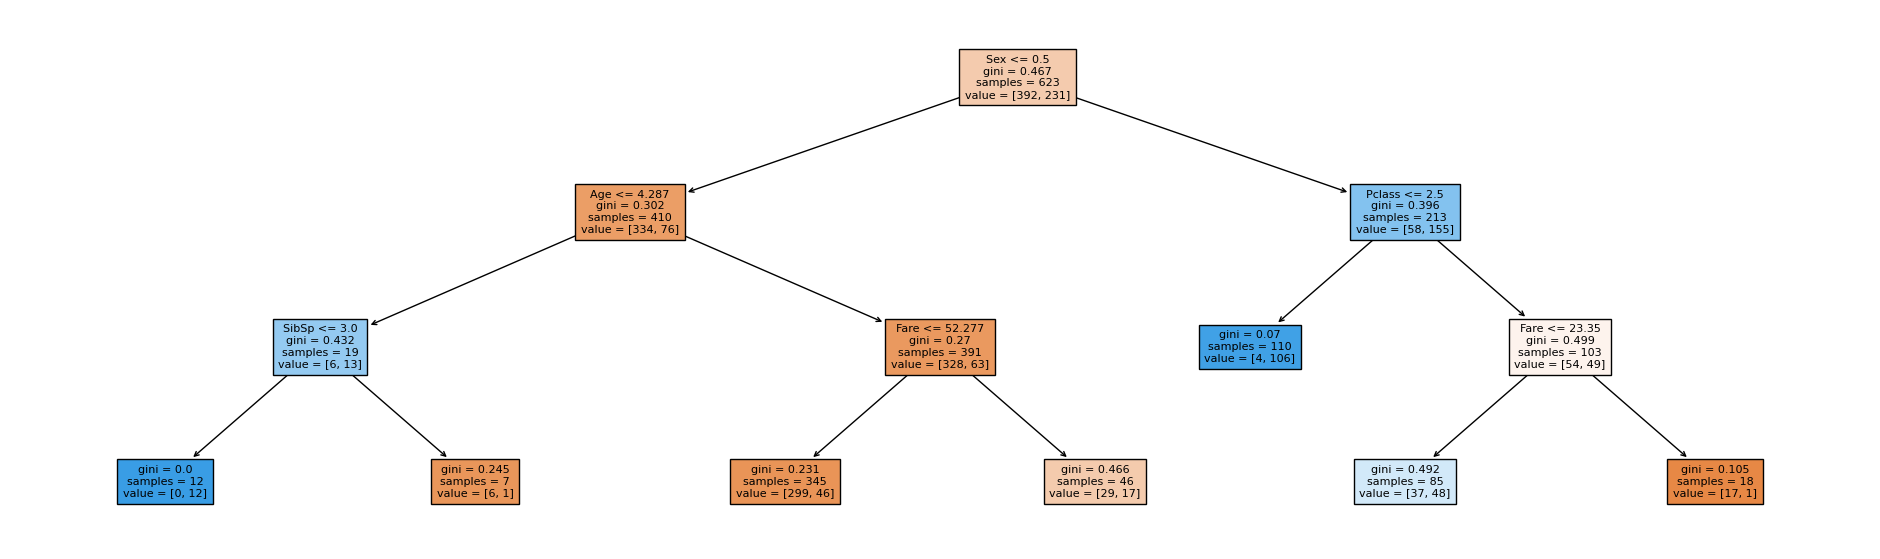

In [20]:
tree_classifier = DecisionTreeClassifier(min_impurity_decrease = 0.005)
tree_classifier.fit(X_train, y_train)
y_pred = tree_classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

plt.figure(figsize=(24, 7))
plot_tree(tree_classifier, filled = True, feature_names=X_train.columns, fontsize = 8)
plt.show()

In [21]:
rforest_classifier = RandomForestClassifier(n_estimators=100, min_impurity_decrease = 0.0025, random_state=1)
rforest_classifier.fit(X_train, y_train)
y_pred = rforest_classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8283582089552238


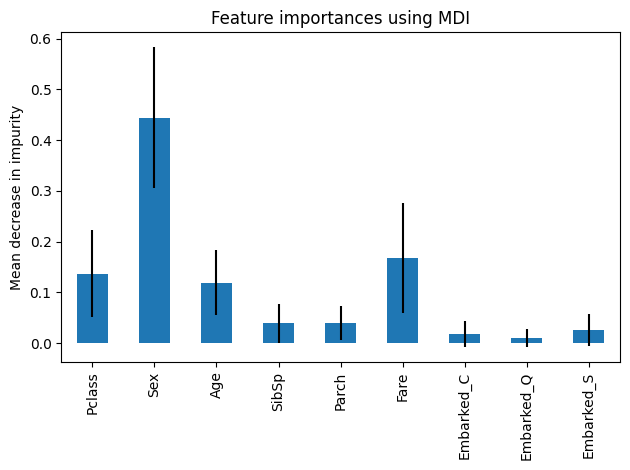

In [22]:
importances = rforest_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rforest_classifier.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [23]:
features_2 = ['Pclass', "Sex", 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked','title','family_size','family_id']
combined_data_2 = pd.get_dummies(pd.concat([train_data,test_data])[features_2])
X_train, X_val, y_train, y_val = train_test_split(combined_data_2[:len(train_data)],
    train_data['Survived'], 
    test_size=0.3, 
    random_state=42
)

hgb_classifier = HistGradientBoostingClassifier(random_state=20, max_leaf_nodes=3)
hgb_classifier.fit(X_train, y_train)
y_pred = hgb_classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.832089552238806


In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=26)

In [25]:
for classifier in [tree_classifier,rforest_classifier]:
    scores = cross_val_score(classifier, combined_data_1[:len(train_data)], train_data['Survived'], cv=kf)
    print("Mean CV score:", np.mean(scores))
    print("Standard deviation of CV scores:", np.std(scores))

Mean CV score: 0.8080597577051034
Standard deviation of CV scores: 0.02705187427779891
Mean CV score: 0.828278199736363
Standard deviation of CV scores: 0.025051844806542337


In [26]:
tree_classifier.fit(combined_data_1[:len(train_data)],train_data['Survived'])
predictions = tree_classifier.predict(combined_data_1[len(train_data):])

In [27]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions.astype(int)})
output.to_csv('submission.csv', index=False)

# Reference

1. Stephens, T. (2014, January 10). Titanic: Getting started with R. Trevor Stephens. https://trevorstephens.com/kaggle-titanic-tutorial/getting-started-with-r/
2. Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, E. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825–2830.
